In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("../.data/processed/noise_data_cleaned.csv")
df.head()

,created_date,complaint_type,descriptor,borough,incident_zip,latitude,longitude,status,year,month,day,hour,day_of_week
0,2025-07-18 23:53:00,Noise,Noise: Construction Before/After Hours (NM1),MANHATTAN,10029.0,40.789950,-73.942927,Open,2025,7,18,23,Friday
1,2025-07-18 23:44:00,Noise,Noise: Construction Before/After Hours (NM1),MANHATTAN,10024.0,40.783600,-73.979428,Open,2025,7,18,23,Friday
2,2025-07-18 23:32:00,Noise,Noise: Construction Before/After Hours (NM1),STATEN ISLAND,10310.0,40.636057,-74.106825,Open,2025,7,18,23,Friday
3,2025-07-18 23:29:00,Noise,"Noise: Boat(Engine,Music,Etc) (NR10)",QUEENS,11357.0,40.791550,-73.795771,Open,2025,7,18,23,Friday
4,2025-07-18 23:26:00,Noise,"Noise: Boat(Engine,Music,Etc) (NR10)",QUEENS,11357.0,40.791550,-73.795771,Open,2025,7,18,23,Friday


### Handling Missing Values

In [3]:
missing_pct = df.isnull().mean().round(4).sort_values(ascending=False) * 100
print(df.isnull().sum())
missing_pct[missing_pct > 0]

created_date          0
complaint_type        0
descriptor            0
borough              60
incident_zip       6852
latitude          11384
longitude         11384
status                0
year                  0
month                 0
day                   0
hour                  0
day_of_week           0
dtype: int64


latitude        1.43
longitude       1.43
incident_zip    0.86
borough         0.01
dtype: float64

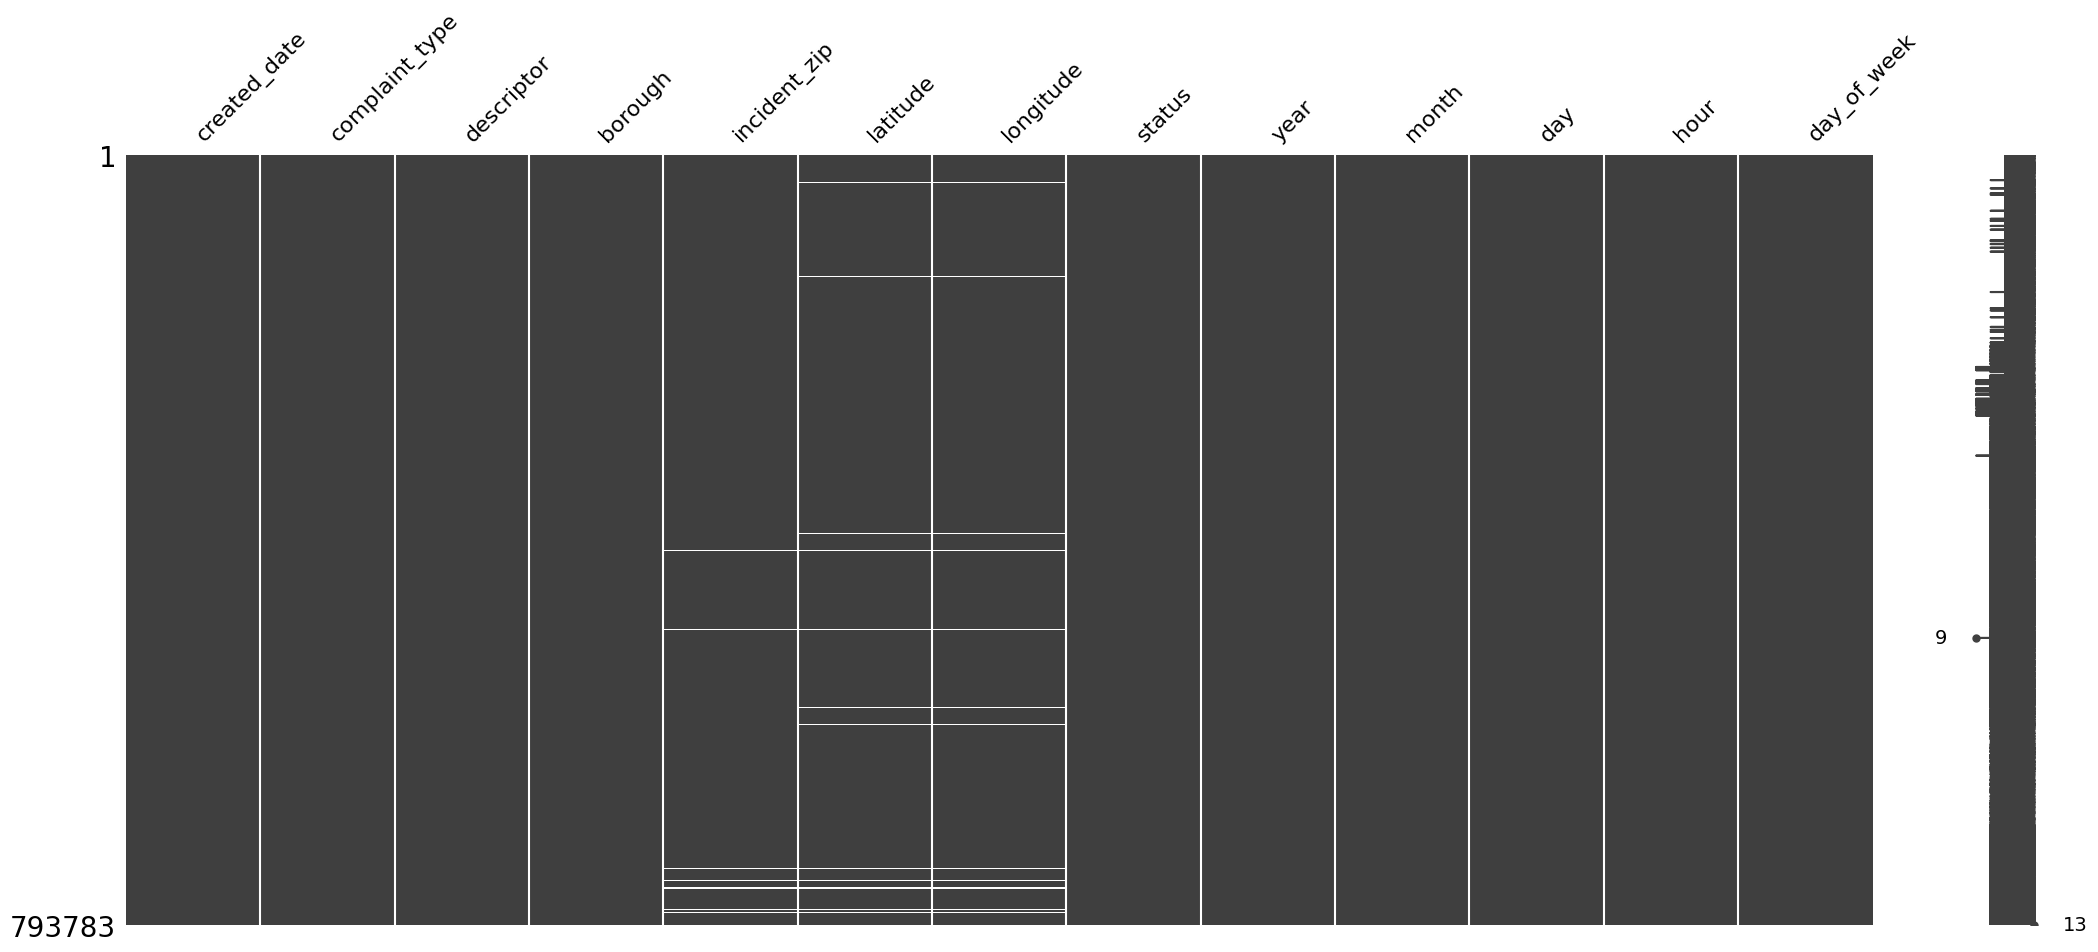

In [4]:
msno.matrix(df)
plt.show()

Lat & Long → missing together → you can’t map them.

Incident Zip → sometimes missing where coords are also missing.

These are spatial identifiers → if more than one is missing together, the row can’t be used for hotspot prediction.

In [5]:
df["borough"] = df["borough"].fillna("UNKNOWN")

df = df.dropna(subset="incident_zip")

In [6]:
missing_pct = df.isnull().mean().round(4).sort_values(ascending=False) * 100
print(df.isnull().sum())
missing_pct[missing_pct > 0]

created_date         0
complaint_type       0
descriptor           0
borough              0
incident_zip         0
latitude          4546
longitude         4546
status               0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
dtype: int64


latitude     0.58
longitude    0.58
dtype: float64

In [11]:
zip_centroids = (
    df.dropna(subset=["latitude", "longitude"])
    .groupby("incident_zip")[["latitude", "longitude"]]
    .mean()
)

In [15]:
df["latitude"] = df.apply(
    lambda row: zip_centroids.loc[row["incident_zip"], "latitude"]
    if pd.isna(row["latitude"]) and row["incident_zip"] in zip_centroids.index
    else row["latitude"],
    axis=1
)

In [14]:
df["longitude"] = df.apply(
    lambda row: zip_centroids.loc[row["incident_zip"], "longitude"]
    if pd.isna(row["longitude"]) and row["incident_zip"] in zip_centroids.index
    else row["longitude"],
    axis=1
)